In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN, KMeans, OPTICS
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score
import warnings
warnings.filterwarnings('ignore')
try:
    import hdbscan
    HDBSCAN_AVAILABLE = True
except:
    HDBSCAN_AVAILABLE = False


In [9]:
df = pd.read_csv("Indian Cities Geo Data.csv")
df.head()

,State,Location,Latitude,Longitude
0,Andaman and Nicobar Islands,Bamboo Flat Latitude and Longitude,11.70000,92.71667
1,Andaman and Nicobar Islands,Nicobar Latitude and Longitude,7.03002,93.79028
2,Andaman and Nicobar Islands,Port Blair Latitude and Longitude,11.66613,92.74635
3,Andaman and Nicobar Islands,South Andaman Latitude and Longitude,10.75776,92.52136
4,Andhra Pradesh,Addanki Latitude and Longitude,15.81061,79.97338


In [10]:
def guess_lat_lon_columns(columns):
    lat_candidates = ["lat", "latitude", "y"]
    lon_candidates = ["lon", "lng", "long", "longitude", "x"]
    lat_col, lon_col = None, None
    for c in columns:
        cl = c.lower()
        if lat_col is None and any(k in cl for k in lat_candidates):
            lat_col = c
        if lon_col is None and any(k in cl for k in lon_candidates):
            lon_col = c
    return lat_col, lon_col

lat_col, lon_col = guess_lat_lon_columns(df.columns)

df[lat_col] = pd.to_numeric(df[lat_col], errors="coerce")
df[lon_col] = pd.to_numeric(df[lon_col], errors="coerce")

df_clean = df.dropna(subset=[lat_col, lon_col]).copy()
df_clean = df_clean[
    df_clean[lat_col].between(-90, 90) & df_clean[lon_col].between(-180, 180)
].drop_duplicates(subset=[lat_col, lon_col])

df_clean.to_csv("cleaned_indian_cities.csv", index=False)
df_clean.head()

,State,Location,Latitude,Longitude
0,Andaman and Nicobar Islands,Bamboo Flat Latitude and Longitude,11.70000,92.71667
1,Andaman and Nicobar Islands,Nicobar Latitude and Longitude,7.03002,93.79028
2,Andaman and Nicobar Islands,Port Blair Latitude and Longitude,11.66613,92.74635
3,Andaman and Nicobar Islands,South Andaman Latitude and Longitude,10.75776,92.52136
4,Andhra Pradesh,Addanki Latitude and Longitude,15.81061,79.97338


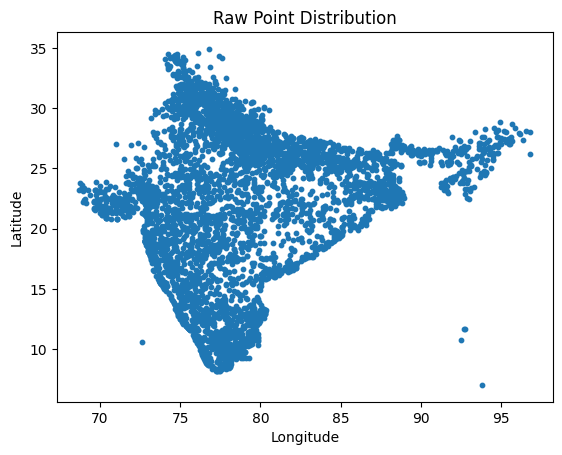

In [11]:
plt.scatter(df_clean[lon_col], df_clean[lat_col], s=10)
plt.title("Raw Point Distribution")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

In [12]:
X = df_clean[[lon_col, lat_col]].to_numpy()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

nbrs = NearestNeighbors(n_neighbors=5).fit(X_scaled)
distances, _ = nbrs.kneighbors(X_scaled)
eps_guess = np.median(np.sort(distances[:, -1])) * 1.5

db = DBSCAN(eps=eps_guess, min_samples=8).fit(X_scaled)
df_clean["dbscan_label"] = db.labels_

best_k, best_score, best_model = None, -1, None
for k in range(2, 9):
    km = KMeans(n_clusters=k, n_init=10, random_state=42)
    labels = km.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    if score > best_score:
        best_k, best_score, best_model = k, score, km
kmeans = best_model
df_clean["kmeans_label"] = kmeans.labels_

if HDBSCAN_AVAILABLE:
    hdb = hdbscan.HDBSCAN(min_cluster_size=10)
    df_clean["hdbscan_label"] = hdb.fit_predict(X_scaled)
else:
    optics = OPTICS(min_samples=10, xi=0.05, min_cluster_size=0.05)
    df_clean["hdbscan_label"] = optics.fit_predict(X_scaled)

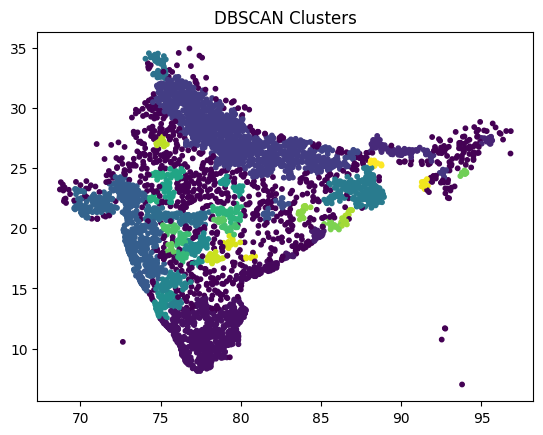

In [14]:
plt.scatter(df_clean[lon_col], df_clean[lat_col], c=df_clean["dbscan_label"], s=10)
plt.title("DBSCAN Clusters")
plt.show()

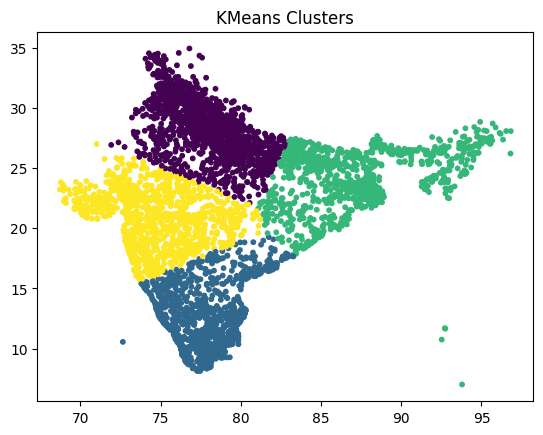

In [15]:
plt.scatter(df_clean[lon_col], df_clean[lat_col], c=df_clean["kmeans_label"], s=10)
plt.title("KMeans Clusters")
plt.show()

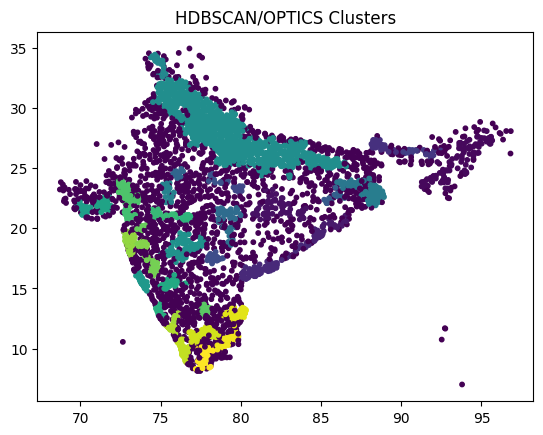

In [16]:
plt.scatter(df_clean[lon_col], df_clean[lat_col], c=df_clean["hdbscan_label"], s=10)
plt.title("HDBSCAN/OPTICS Clusters")
plt.show()

In [18]:
df_clean["dbscan_outlier"] = df_clean["dbscan_label"] == -1

centers = kmeans.cluster_centers_
dists = np.linalg.norm(X_scaled - centers[kmeans.labels_], axis=1)
thr = [np.percentile(dists[kmeans.labels_ == cl], 95) for cl in np.unique(kmeans.labels_)]
kmeans_outlier = np.zeros(len(df_clean), dtype=bool)
for i, cl in enumerate(np.unique(kmeans.labels_)):
    mask = kmeans.labels_ == cl
    kmeans_outlier[mask] = dists[mask] > thr[i]
df_clean["kmeans_outlier"] = kmeans_outlier

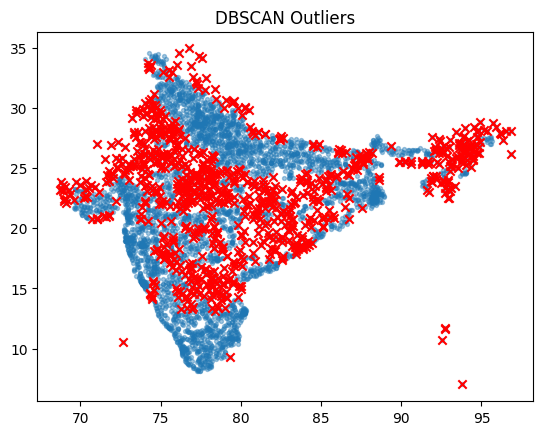

In [19]:
plt.scatter(df_clean[lon_col], df_clean[lat_col], s=8, alpha=0.4)
plt.scatter(df_clean.loc[df_clean["dbscan_outlier"], lon_col],
            df_clean.loc[df_clean["dbscan_outlier"], lat_col], c="red", marker="x")
plt.title("DBSCAN Outliers")
plt.show()

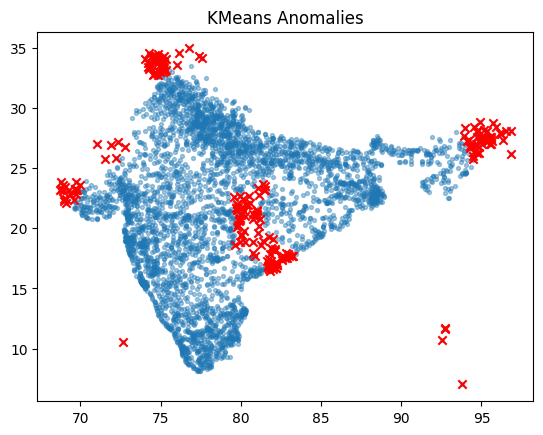

In [20]:
plt.scatter(df_clean[lon_col], df_clean[lat_col], s=8, alpha=0.4)
plt.scatter(df_clean.loc[df_clean["kmeans_outlier"], lon_col],
            df_clean.loc[df_clean["kmeans_outlier"], lat_col], c="red", marker="x")
plt.title("KMeans Anomalies")
plt.show()

In [21]:
def cluster_summary(label_col):
    return df_clean.groupby(label_col).agg(
        count=(label_col, "size"),
        mean_lat=(lat_col, "mean"),
        mean_lon=(lon_col, "mean")
    ).sort_values("count", ascending=False)

summary_db = cluster_summary("dbscan_label")
summary_km = cluster_summary("kmeans_label")
summary_hdb = cluster_summary("hdbscan_label")

summary_db.head(), summary_km.head(), summary_hdb.head()

(              count   mean_lat   mean_lon
 dbscan_label                             
  8             1046  27.864322  79.425825
 -1              883  23.034719  80.293083
  1              551  11.246203  77.901140
  14             442  19.798455  73.469459
  20             263  23.021062  87.573653,
               count   mean_lat   mean_lon
 kmeans_label                             
 0              1190  28.144716  77.966362
 3              1119  20.621473  74.621211
 2               964  23.982970  87.193240
 1               942  13.126050  77.831104,
                count   mean_lat   mean_lon
 hdbscan_label                             
 -1              1745  20.982744  78.573853
  20              930  27.950502  79.306881
  17              132  22.720404  88.303061
  0                95  25.584487  93.580027
  35               90  18.965684  72.982824)

In [22]:
print("Total points:", len(df_clean))
print("DBSCAN clusters:", df_clean["dbscan_label"].nunique() - (1 if -1 in df_clean["dbscan_label"].unique() else 0))
print("KMeans clusters:", df_clean["kmeans_label"].nunique())
print("HDBSCAN/OPTICS clusters:", df_clean["hdbscan_label"].nunique() - (1 if -1 in df_clean["hdbscan_label"].unique() else 0))
print("DBSCAN outliers:", df_clean["dbscan_outlier"].sum())
print("KMeans anomalies:", df_clean["kmeans_outlier"].sum())

Total points: 4215
DBSCAN clusters: 51
KMeans clusters: 4
HDBSCAN/OPTICS clusters: 43
DBSCAN outliers: 883
KMeans anomalies: 213


#CONCLUSION

Based on the geospatial clustering analysis of the Indian cities dataset, a total of 4,215 valid data points were processed after cleaning. Using DBSCAN, 51 spatial clusters were identified, along with 883 points flagged as outliers. In comparison, K-Means produced a more compact structure with 4 major clusters and 213 anomalies detected, while HDBSCAN/OPTICS identified 43 clusters, demonstrating its ability to capture variable-density clusters. The differences in results highlight the sensitivity of clustering algorithms to data distribution and parameter selection. DBSCAN was effective in detecting finer-grained, local groupings and outliers scattered across the map, while K-Means provided broader regional clusters, offering a higher-level view of spatial concentration. HDBSCAN/OPTICS balanced these approaches by identifying meaningful clusters with fewer parameter constraints. Overall, the analysis shows that Indian cities exhibit both macro-level spatial concentration and localized clusters, with notable anomalies indicating cities that deviate from regional clustering patterns. This comparative approach demonstrates the importance of applying multiple clustering methods to gain richer insights into geospatial patterns and anomalies.